# Section 1: Business Understanding

Visiting a city for the first time can be overwhelming. And the place we stay at can have a big impact in how we perceive the city. 

We can always look for posts on Google and we'll probably find very useful information. However, this is inevitably biased by the author's personal experience and interests.

Given that Airbnb shares big portions of the data they collect, we can use that and try to draw more objetive conclusions.


Madrid (Spain) was the chosen city for this analysis, but the same process could be applied to many other big cities. This analysis was structured around one main question and 3 sub questions:

### Main question: What is the best spot/area to stay in Madrid?

##### Sub Question 1. Where do people tend to give a higher location rating?
##### Sub Question 2. Where are there more options to choose from?
##### Sub Question 3. Are the best areas too expensive?

In [458]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Section 2: Data Understanding

### Gather data

We downloaded the list of Airbnb accommodations available in Madrid (Spain) -updated September 2022-.

In [459]:
# Import Airbnb data
df_listings = pd.read_csv('./listings.csv')
df_listings.shape

(20681, 75)

We'll define some points here that will help us give some geographical references for our analysis: the three most touristic districts (https://misstourist.com/where-to-stay-in-madrid-spain-best-hotels/) and the airport.

In [460]:
geo_ref = {'text':      ["Salamanca", "Retiro",  "Centro", "Airport MAD"],
           'longitude': [     -3.674,   -3.677,    -3.705,        -3.595],
           'latitude':  [     40.430,   40.411,    40.417,        40.496]}

### Describe data
Let's see which kind of information we can find in the dataset:

In [461]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

It seems we have a lot of useful information here. We can locate each accommodation geographically. We can see the score people gave them -actually divided into different categories-. And we also have means to measure how active a house has been lately, how many reviews it got, etc.

### Explore data
Let's make a scatter plot according to longitude, latitude and the location score.

We'll actually create a function for this, because this is a process we'll repeat several times.

In [463]:
def scatterplot(df, col_c, text_col_c, geo_ref_start, geo_ref_end, margin=0.01):
    """    
    This function displays a scatter plot, containing one point for each row of the dataframe. 
    Coordinates x (longitude) and y (latitude) are both directly read from the dataframe.
    Coordinate c (color) will depend on the parameter the user specifies. 
    Some geographical references will be included, depending on the indexes provided. 
    
    Inputs:
    -----
    df: data frame
    col_c: name of column c
    test_col_c: text to be displayed next to c axis
    geo_ref_start, geo_ref_end: range of values to be read from geo_ref
    margin (optional): distance between icons and text displayed from geo_ref (default: 0.01)
    
    Output:
    -----
    A geographically consistent scatter plot, including some references.
    
    """
    df_plot = pd.DataFrame({'longitude': df['longitude'], 'latitude': df['latitude'], text_col_c: df[col_c]})
    ax = df_plot.plot(kind='scatter', x='longitude', y='latitude', c=text_col_c, colormap='cividis')

    for x in range(geo_ref_start, geo_ref_end):
        ax.plot(geo_ref['longitude'][x], geo_ref['latitude'][x], "*r")
        ax.annotate(geo_ref['text'][x], (geo_ref['longitude'][x]+margin, geo_ref['latitude'][x]))

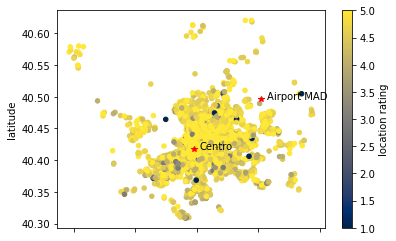

In [344]:
# Make a scatter plot according to location rating (including Centro and Airport as references)
scatterplot(df_listings,'review_scores_location','location rating', 2, 4)

It doesn't make much sense that there are places with the highest location score all over the map. That probably means those are brand new accommodations that were only used, so far, by people who are close to the owners (friends or family). So we'll need to handle this in the next section.

### Verify data quality
Let's also check if we're maybe trying to plot some NaN values. Because that would mean we're wasting computing power:

In [345]:
# Check for NaN values
df_listings['review_scores_location'].isnull().sum()

4614

That's indeed the case, so that's another factor to take into consideration for the next section.

It's also important to note that, at this point, it's not possible to make a scatter plot using price as the coordinate c, because the prices are written as strings. We'll need to re-format that column.

# Section 3: Data Preparation
### Select data
We need latitude and longitude to place the elements geographically. We need the number of reviews to filter the data and make sure our conclusions are as objective as possible. And we need the price and the location score to answer our questions.

In [464]:
# Keep the useful columns
df_select = df_listings[['latitude', 'longitude', 'number_of_reviews', 'price', 'review_scores_location']]
df_select.shape

(20681, 5)

### Clean data
Now, let's see what happens if we establish a minimum number of reviews:

(6111, 5)

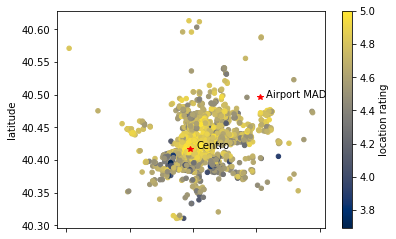

In [347]:
# Only keep houses with a minimum number of reviews 
min_reviews = 30
df_clean = df_select[df_select['number_of_reviews'] > min_reviews]

# Make a scatter plot according to location rating (including Centro and Airport as references)
scatterplot(df_clean,'review_scores_location','location rating', 2, 4)

# Let's see the new size
df_clean.shape

After some trial and error, it seems that a minimum of 30 reviews makes the scatter plot way more meaningful.

Now, let's see if we can zoom in a little bit so the scatter plot is even more visual. We'll use percentiles.

(5645, 5)

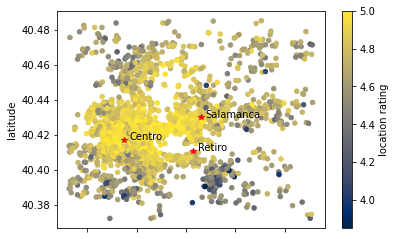

In [348]:
### Establish the limits according to a percentile
perc_lat = 0.01
perc_long = 0.03
min_lat  = df_clean['latitude'].quantile(perc_lat)
max_lat  = df_clean['latitude'].quantile(1-perc_lat)
min_long = df_clean['longitude'].quantile(perc_long)
max_long = df_clean['longitude'].quantile(1-perc_long)

# Zoom in
df_zoom = df_clean[(df_clean['latitude']  > min_lat)  & 
                   (df_clean['latitude']  < max_lat)  &
                   (df_clean['longitude'] > min_long) & 
                   (df_clean['longitude'] < max_long)  ]

# Make a scatter plot according to location rating (including Salamanca, Retiro and Centro as references)
scatterplot(df_zoom,'review_scores_location','location rating', 0, 3, 0.002)
    
df_zoom.shape

Again, by trial and error, we found that dropping 1% of the values north and south and 3% of the values east and west allows us to reduce the number of elements and still see the same patterns on the scatter plot. 


Finally, let's drop the rows with NaN values on the location score column.

In [349]:
# Drop rows with NaN values 
df_drop = df_zoom.dropna(subset=['review_scores_location'])
df_drop.shape

(5645, 5)

This step didn't affect the size of the dataframe. It seems that we already dropped the NaN values when we filtered by the number of reviews.

### Format data
We'll remove the $ from the price column, so it can be treated as a float.

In [350]:
# Convert price column to float
df_drop[df_drop.columns[3:]] = df_drop[df_drop.columns[3:]].replace('[\$,]', '', regex=True).astype(float)
df_drop.shape

(5645, 5)

### Construct data
We'll go over the map and create a grid of 1km by 1km squares. Then, we'll evaluate each square and make three calculations: average location rating, number of houses and median of the prices.  

Given that our scatter plots use geographic coordinates, we need to convert 1km into degrees of latitude and degrees of longitude (https://www.johndcook.com/how_big_is_a_degree.html). This is why our squares will look like rectangles on the scatter plots.

In [465]:
# Define the step (approx. 1 km in both cases)
step_long = 0.012  
step_lat = 0.009  

# Find the amount of longitude and latitude subdivisions according to the step
long_steps = math.ceil((max_long - min_long)/step_long)
lat_steps = math.ceil((max_lat - min_lat)/step_lat)

# Initialize the data frame where we'll store the results
grid_results = pd.DataFrame([[min_long-step_long, min_lat-step_lat,     float('nan'),    float('nan'),   float('nan')]],
                            columns=['longitude',       'latitude',  'avg_loc_score', 'num_of_houses', 'median_price'])

Now, let's create the grid:

In [466]:
# Populate the new data frame
for x in range(long_steps):
    subset_x = df_drop[(df_drop['longitude'] > min_long+( x )*step_long)& 
                       (df_drop['longitude'] < min_long+(x+1)*step_long)]
    for y in range(lat_steps): 
            subset_y = subset_x[(subset_x['latitude'] > min_lat+( y )*step_lat)& 
                                (subset_x['latitude'] < min_lat+(y+1)*step_lat)]
            
            avg_loc_score = round((subset_y['review_scores_location']).mean(), 2)
            num_of_houses = subset_y.shape[0]
            median_price  = round((subset_y['price']).median(), 2)
            
            new_row = pd.DataFrame([[min_long+(x)*step_long, min_lat+(y)*step_lat, avg_loc_score,    num_of_houses,  median_price]],
                                       columns=['longitude',           'latitude','avg_loc_score', 'num_of_houses', 'median_price'])
            grid_results = pd.concat([grid_results, new_row], ignore_index=True)

# Remove the row used to initialize the data frame 
grid_results = grid_results.dropna() 
grid_results.shape


(101, 5)

Now, before we move on to the evaluation phase, we need to filter our resulting grid. 

As we're looking for the best spot/areas to stay at, we're going to keep only those areas with a minimum score of 4.5. 

Also, we don't want an area with very few houses to show, because we're evaluating touristic spots. So we're only going to keep areas containing a minimum of 10 houses.

In [467]:
# Establish minima
min_score = 4.5  
min_num_of_houses = 10

# Apply the filter
grid_filter = grid_results[(grid_results['avg_loc_score'] > min_score        )&
                           (grid_results['num_of_houses'] > min_num_of_houses)]

grid_filter.shape

(47, 5)

# Section 4: Modeling
No statistical models were used in this project.

# Section 5: Evaluation
### Evaluate results
Now, we'll visualize the grid we created, so we can answer the questions we posed at the beginning:

#### Sub Question 1: Where do people tend to give a higher location rating?
Let's make a scatter plot according to the average location scores:

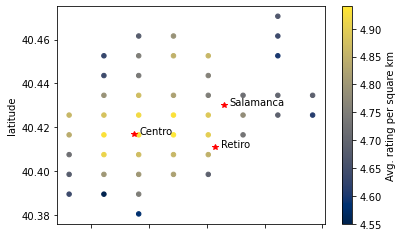

In [451]:
# Make a scatter plot according to location rating (including Salamanca, Retiro and Centro as references)
scatterplot(grid_filter,'avg_loc_score','Avg. rating per square km', 0, 3, 0.002)

It seems that most of the Centro district is very well rated, specially the central area and the limits with the other two districts. 

Let's see the top 10 most liked areas as a list, so we can look them up on Google Maps and see exactly where they are.

In [468]:
grid_best_scores = grid_filter.sort_values(by=['avg_loc_score'], ascending=False)
grid_best_scores.head(10)

,longitude,latitude,avg_loc_score,num_of_houses,median_price
45,-3.691407,40.416594,4.94,64.0,134.5
32,-3.703407,40.416594,4.93,691.0,94.0
46,-3.691407,40.425594,4.93,59.0,134.0
19,-3.715407,40.416594,4.93,799.0,104.0
33,-3.703407,40.425594,4.92,135.0,87.0
18,-3.715407,40.407594,4.91,1004.0,101.0
58,-3.679407,40.416594,4.90,94.0,94.5
59,-3.679407,40.425594,4.89,75.0,84.0
20,-3.715407,40.425594,4.88,190.0,86.0
34,-3.703407,40.434594,4.87,49.0,82.0


The top 10 most liked areas are the following:
1. Paseo del Prado (limit Centro-Retiro) [45]
2. Puerta del Sol (Centro) [32]
3. Colón (limit Centro-Salamanca) [46]
4. Palacio Real (W of Centro) [19]
5. Malasaña (N of Centro) [33]
6. La Latina (SW of Centro) [18]
7. Ibiza (N of Retiro) [58]
8. Píncipe de Vergara (SW of Salamanca) [59]
9. Princesa (NW of Centro) [20]
10. Chamberí (another district, going north from Centro) [34] 


#### Sub Question 2: Where are there more options to choose from?
Now, let's display the grid, according to the amount of houses per square km. 

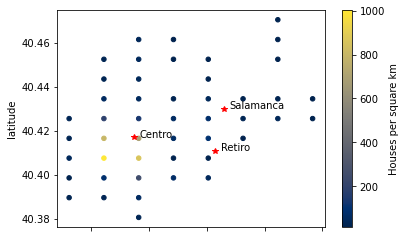

In [469]:
# Make a scatter plot according to the amount of houses (including Salamanca, Retiro and Centro as references)
scatterplot(grid_filter,'num_of_houses','Houses per square km', 0, 3, 0.002)

It seems the southwest quarter of the Centro district contains by far the highest amount of houses.

Let's see the top 10 as a list, so we can look them up on Google Maps and see exactly where they are.

In [455]:
grid_highest_density = grid_filter.sort_values(by=['num_of_houses'], ascending=False)
grid_highest_density.head(10)

,longitude,latitude,avg_loc_score,num_of_houses,median_price
18,-3.715407,40.407594,4.91,1004.0,101.0
31,-3.703407,40.407594,4.87,864.0,93.0
19,-3.715407,40.416594,4.93,799.0,104.0
32,-3.703407,40.416594,4.93,691.0,94.0
30,-3.703407,40.398594,4.80,248.0,80.0
20,-3.715407,40.425594,4.88,190.0,86.0
33,-3.703407,40.425594,4.92,135.0,87.0
58,-3.679407,40.416594,4.90,94.0,94.5
17,-3.715407,40.398594,4.80,83.0,72.0
59,-3.679407,40.425594,4.89,75.0,84.0


The top 10 of areas containing more houses are:
1. La Latina (SW of Centro) [18]
2. Lavapiés (S of Centro) [31]
3. Palacio Real (W of Centro) [19]
4. Puerta del Sol (Centro) [32]
----
5. Acacias (another district, going south from Centro) [30] 
6. Princesa (NW of Centro) [20]
7. Malasaña (N of Centro) [33]
8. Ibiza (N of Retiro) [58]
9. Pirámides (another district, going SW from Centro) [17]
10. Píncipe de Vergara (SW of Salamanca) [59]

We can observe an important difference between the top 4 and the rest.

#### Sub Question 3: Are the best areas too expensive?
Let's visualize the median of the prices for each area.

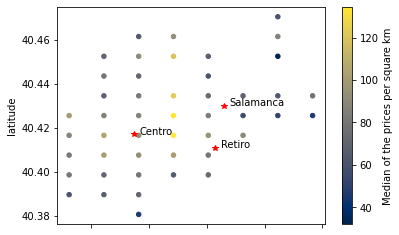

In [456]:
# Make a scatter plot according to prices (including Salamanca, Retiro and Centro as references)
scatterplot(grid_filter,'median_price','Median of the prices per square km', 0, 3, 0.002)

The most expensive areas seem to be the limits Centro-Retiro and Centro-Salamanca, and it keeps going north to other less touristic areas. The southwest quarter of the Centro district seems to go next, with more intermediate prices.

Let's see the top 10 as a list:

In [457]:
grid_highest_prices = grid_filter.sort_values(by=['median_price'], ascending=False)
grid_highest_prices.head(10)

,longitude,latitude,avg_loc_score,num_of_houses,median_price
45,-3.691407,40.416594,4.94,64.0,134.5
46,-3.691407,40.425594,4.93,59.0,134.0
47,-3.691407,40.434594,4.82,21.0,123.0
49,-3.691407,40.452594,4.85,15.0,119.0
19,-3.715407,40.416594,4.93,799.0,104.0
18,-3.715407,40.407594,4.91,1004.0,101.0
44,-3.691407,40.407594,4.86,18.0,100.5
7,-3.727407,40.425594,4.86,28.0,100.0
58,-3.679407,40.416594,4.90,94.0,94.5
32,-3.703407,40.416594,4.93,691.0,94.0


The 10% most expensive areas are:
1. Paseo del Prado (limit Centro-Retiro) [45]
2. Colón (limit Centro-Salamanca) [46]
3. US Embassy (another district, going northeast from Centro) [47]
4. Santiago Bernabeu (another district, going north from the US Embassy) [49]
5. Palacio Real (W of Centro) [19]
6. La Latina (SW of Centro) [18]
7. Atocha (southernmost limit Centro-Retiro) [44]
8. Parque del Oeste (another district, going west and slightly north from Centro) [7]
9. Ibiza (N of Retiro) [58]
10. Puerta del Sol (Centro) [32]

### Main Question: What is the best spot/area to stay in Madrid?
According to our results, the best option would be Puerta del Sol. It is the 2nd best rated area, it's the 4th one in number of options, and it's the 10th one in price. So that looks like a very good compromise for any type of tourist.

The next positions would depend on each person's interests and budget: 

If we're still looking for a compromise, La Latina or Palacio Real could be good options. La Latina is the 6th best rated, the number 1 in terms of options and 6th one in price. Palacio Real is the 4th best rated, 3rd one in terms of options and 5th most expensive. 


Finally, if we have clear preferences, maybe Paseo del Prado or Lavapiés. Paseo del Prado is the best rated location, but there are just a few options, and they're quite pricey. So that's definitely for people who can afford it. On the other hand, Lavapiés might be a wise option for people traveling on a budget. It's not among the preferred areas, but it has a great variety of options and it's not as expensive. 

### Review process
The goals for this project were mostly accomplished, as we could answer the questions we posed at the beginning. 

A possible improvement would be focusing more on the actual neighborhoods, instead of a grid of equally sized areas. Because, for instance, the results for Palacio Real could be misleading. The values obtained there correspond to the eastern half of that area, which is actually the south of Gran Vía and the north of La Latina. 

# Section 6: Deployment
### Produce final report
Please, check this post on Medium: 

https://medium.com/@jose.adan.imedio/this-is-the-best-area-to-stay-in-madrid-according-to-airbnb-data-d38f76a01577